In [1]:
# Notebook: Stationarity and ARIMA Foundations for Econometric Modeling
# ----------------------------------------------------------------------
# GOAL: Understand the building blocks for cointegration, ECM, and custom signal dynamics
# Core topics: Stationarity, unit root tests, AR/MA models, lag operators, ARIMA simulation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
import scipy.stats as sc
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.signal import lfilter

In [3]:
# ------------------------
# STEP 2: What is Stationarity?
# ------------------------
# 1. Simulate a white noise process (mean 0, std 1)
# 2. Simulate a random walk: X[t] = X[t-1] + eps[t]
# 3. Plot both series and their rolling stats (mean, std)
# 4. Visually compare stationarity

In [4]:
n = 30000
white_noise = np.random.randn(n)

In [5]:
X = [0]
for t in range(1, n):
  X.append(X[-1]+ white_noise[t])

In [6]:
df = pd.DataFrame({
    "X": X,
    "white_noise": white_noise
})

In [7]:
def compute_rolling_stats(series, period = 20):
  rolling_mean = series.rolling(window=period, min_periods=period).mean()
  rolling_std = series.rolling(window=period, min_periods=period).std()
  plt.plot(series)
  plt.show()
  plt.plot(rolling_mean)
  plt.show()
  plt.plot(rolling_std)
  plt.show()


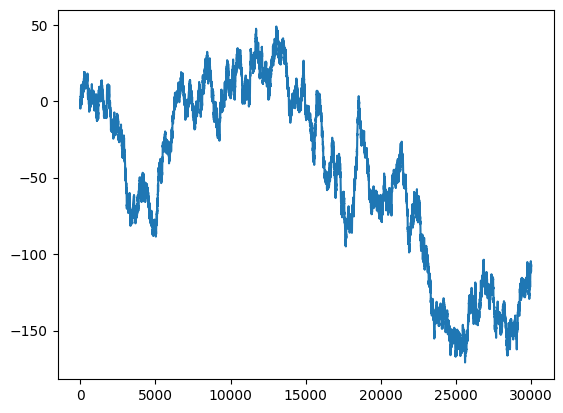

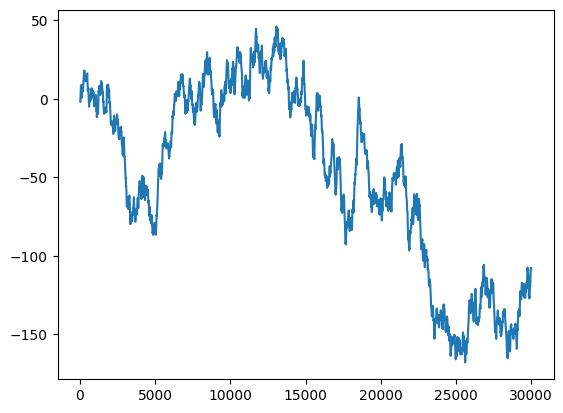

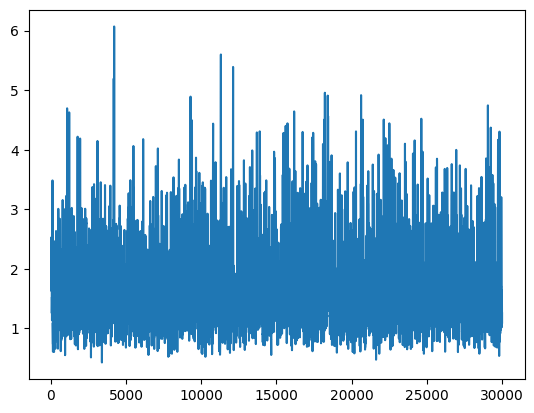

In [8]:
compute_rolling_stats(df['X'])

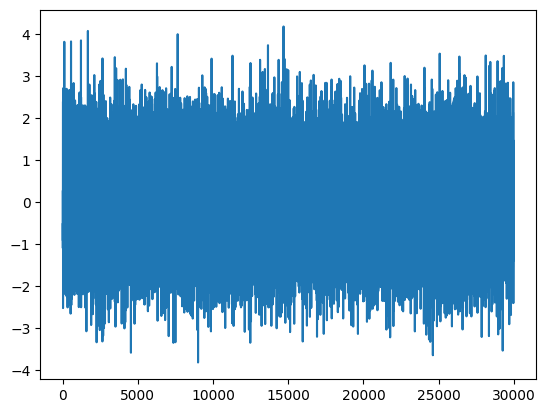

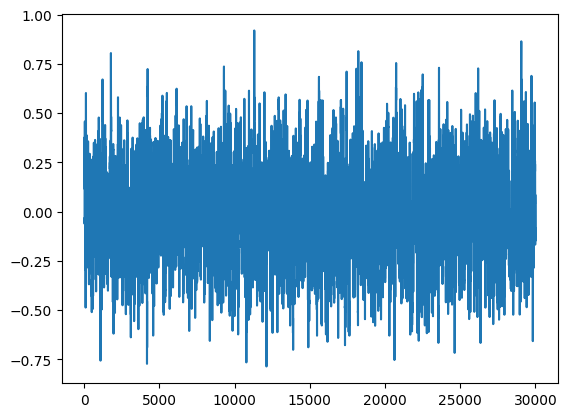

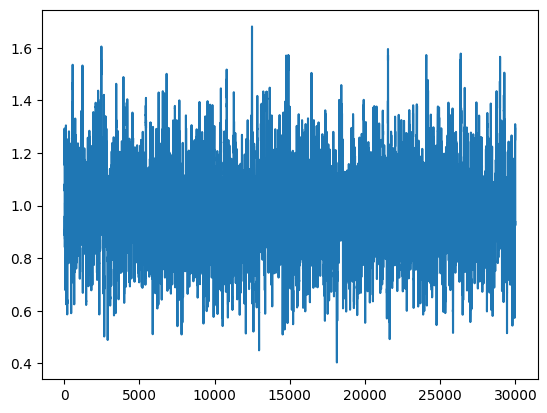

In [9]:
compute_rolling_stats(df['white_noise'])

In [10]:
# ------------------------
# STEP 3: Augmented Dickey-Fuller (ADF) Test
# ------------------------
# Apply ADF test to both series
# Report test statistic, p-value, and critical values
# Interpret whether each series is stationary

In [11]:
val, p_val, _, _, cv, _ = adfuller(white_noise, maxlag=5)
print(f"val:{val}, p_val:{p_val}, cvs:{cv}")

val:-173.7017847834765, p_val:0.0, cvs:{'1%': np.float64(-3.4305680025880942), '5%': np.float64(-2.8616363512511263), '10%': np.float64(-2.5668212848307097)}


In [12]:
val, p_val, _, _, cv, _ = adfuller(df['X'], maxlag=5)
print(f"val:{val}, p_val:{p_val}, cvs:{cv}")

val:-1.4106119854643873, p_val:0.5771781581706152, cvs:{'1%': np.float64(-3.4305680025880942), '5%': np.float64(-2.8616363512511263), '10%': np.float64(-2.5668212848307097)}


In [13]:
# ------------------------
# STEP 4: Build AR(1) and AR(2) Models
# ------------------------
# 1. Simulate AR(1): X[t] = 0.7*X[t-1] + eps[t]
# 2. Simulate AR(2): X[t] = 0.5*X[t-1] - 0.2*X[t-2] + eps[t]
# 3. Plot the autocorrelation (ACF) and partial autocorrelation (PACF)
# 4. Fit using statsmodels.tsa.ARIMA (with order=(1,0,0) and (2,0,0))

In [14]:
X1 = [0]
for t in range(1, n):
  X1.append(0.7*X1[-1]+ np.random.randn())

In [15]:
X2 = [0, 0]
for t in range(1, n):
  X2.append(0.5 * X2[-1] - 0.2 * X2[-2]+ np.random.randn())

In [16]:
def plot_graphs(series):
  # Create side-by-side ACF and PACF plots
  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  # Plot ACF
  plot_acf(series, ax=axes[0], lags=40, title='Autocorrelation Function (ACF) of series')
  axes[0].grid(True)

  # Plot PACF with Yule-Walker method
  plot_pacf(series, ax=axes[1], lags=40, method='ywm', title='Partial Autocorrelation Function (PACF) of series')
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()

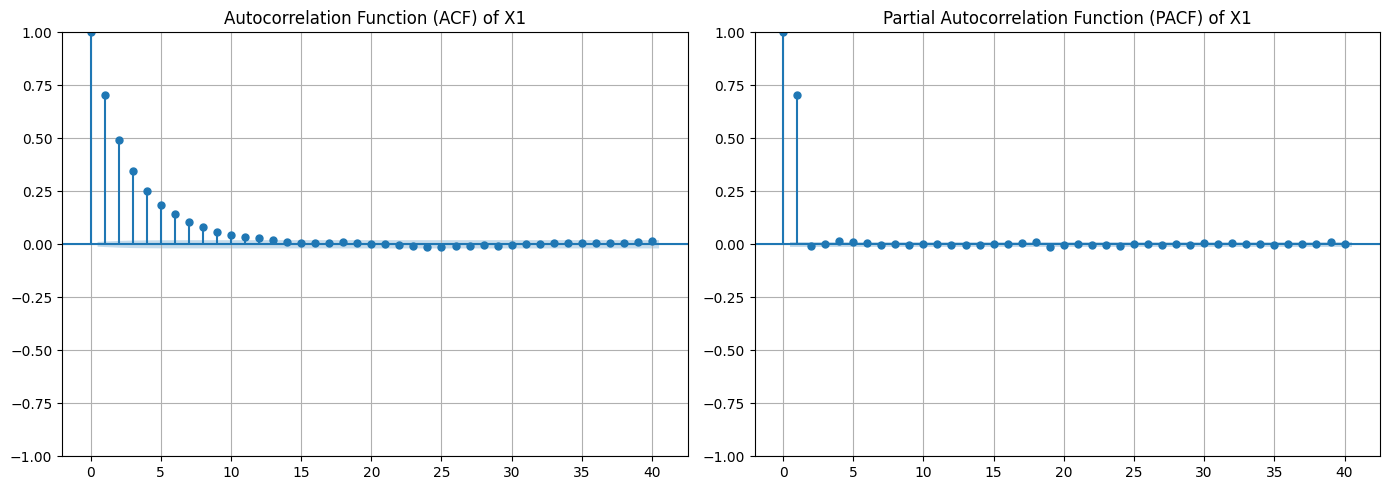

In [17]:
series_X1 = pd.Series(X1)

# Create side-by-side ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot ACF
plot_acf(series_X1, ax=axes[0], lags=40, title='Autocorrelation Function (ACF) of X1')
axes[0].grid(True)

# Plot PACF with Yule-Walker method
plot_pacf(series_X1, ax=axes[1], lags=40, method='ywm', title='Partial Autocorrelation Function (PACF) of X1')
axes[1].grid(True)

plt.tight_layout()
plt.show()

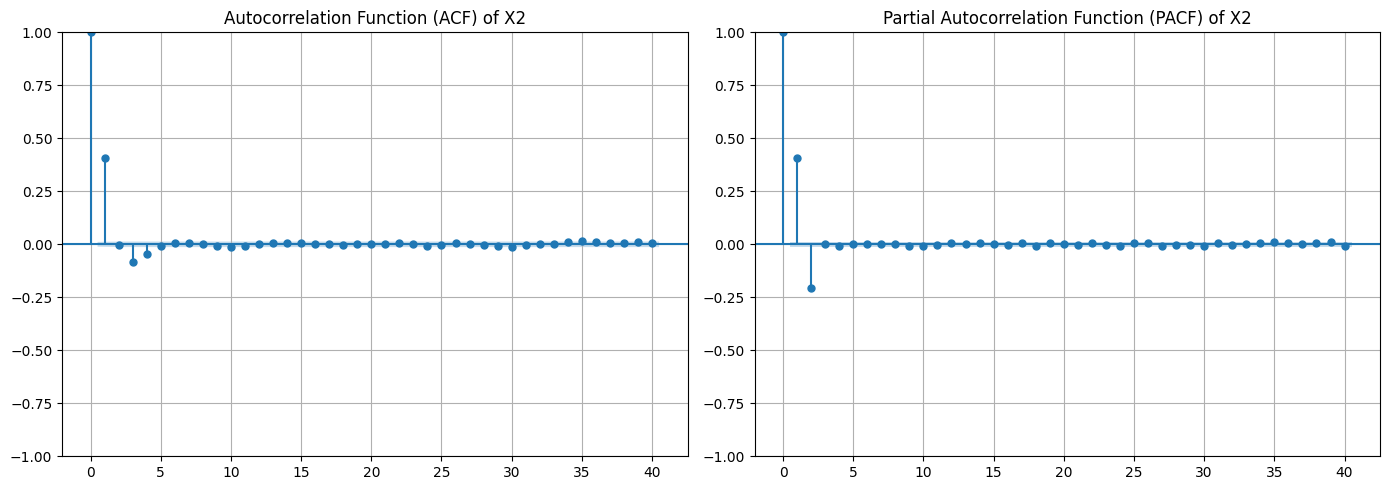

In [18]:
series_X2 = pd.Series(X2)

# Create side-by-side ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot ACF
plot_acf(series_X2, ax=axes[0], lags=40, title='Autocorrelation Function (ACF) of X2')
axes[0].grid(True)

# Plot PACF with Yule-Walker method
plot_pacf(series_X2, ax=axes[1], lags=40, method='ywm', title='Partial Autocorrelation Function (PACF) of X2')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [19]:
mod_X1 = ARIMA(series_X1, order=(1, 0, 0))
res_X1 = mod_X1.fit()
print(res_X1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30000
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -42611.310
Date:                Wed, 21 May 2025   AIC                          85228.619
Time:                        22:54:34   BIC                          85253.546
Sample:                             0   HQIC                         85236.617
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0209      0.020     -1.069      0.285      -0.059       0.017
ar.L1          0.7042      0.004    172.245      0.000       0.696       0.712
sigma2         1.0028      0.008    121.360      0.0

In [20]:
mod_X2 = ARIMA(series_X2, order=(2, 0, 0))
res_X2 = mod_X2.fit()
print(res_X2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30001
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -42555.164
Date:                Wed, 21 May 2025   AIC                          85118.329
Time:                        22:54:41   BIC                          85151.565
Sample:                             0   HQIC                         85128.993
                              - 30001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0084      0.008     -1.039      0.299      -0.024       0.007
ar.L1          0.4918      0.006     86.538      0.000       0.481       0.503
ar.L2         -0.2052      0.006    -36.018      0.0

In [21]:
# ------------------------
# STEP 5: MA and ARMA Models
# ------------------------
# 1. Simulate MA(1): X[t] = eps[t] + 0.5*eps[t-1]
# 2. Simulate ARMA(1,1): X[t] = 0.6*X[t-1] + eps[t] + 0.4*eps[t-1]
# 3. Plot ACF/PACF — observe decay patterns
# 4. Fit ARMA(1,1) model using statsmodels and report parameters

In [22]:
X3 = [white_noise[0]]
X4 = [0]
for t in range(1, n):
  X3.append(white_noise[t] + 0.5 * white_noise[t-1])
  X4.append(0.6 * X4[-1] + white_noise[t] + 0.4 * white_noise[t-1])

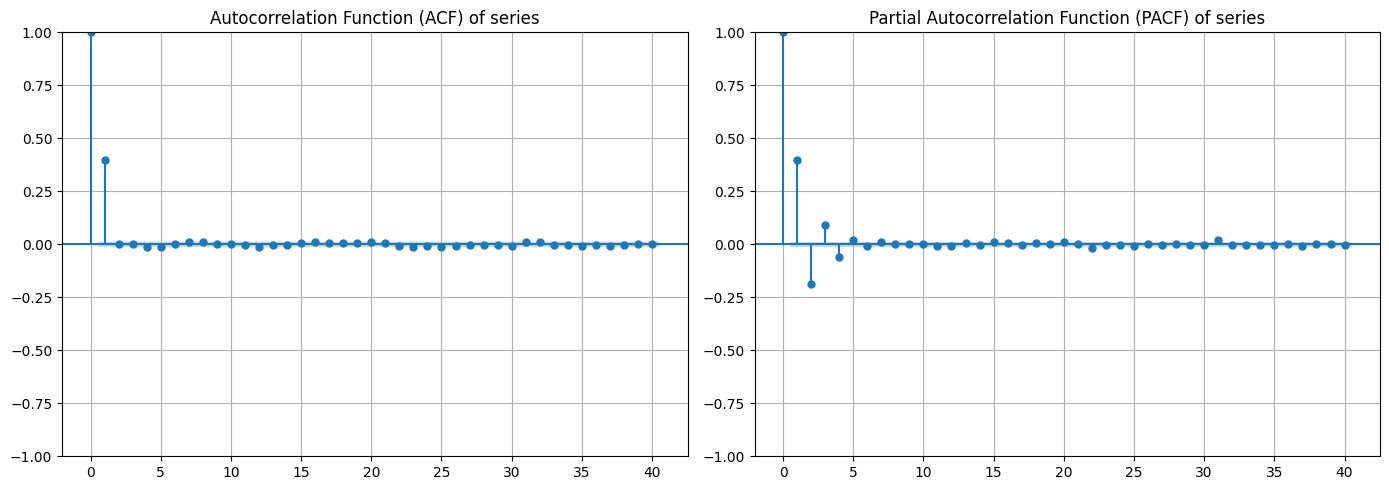

In [23]:
plot_graphs(pd.Series(X3))

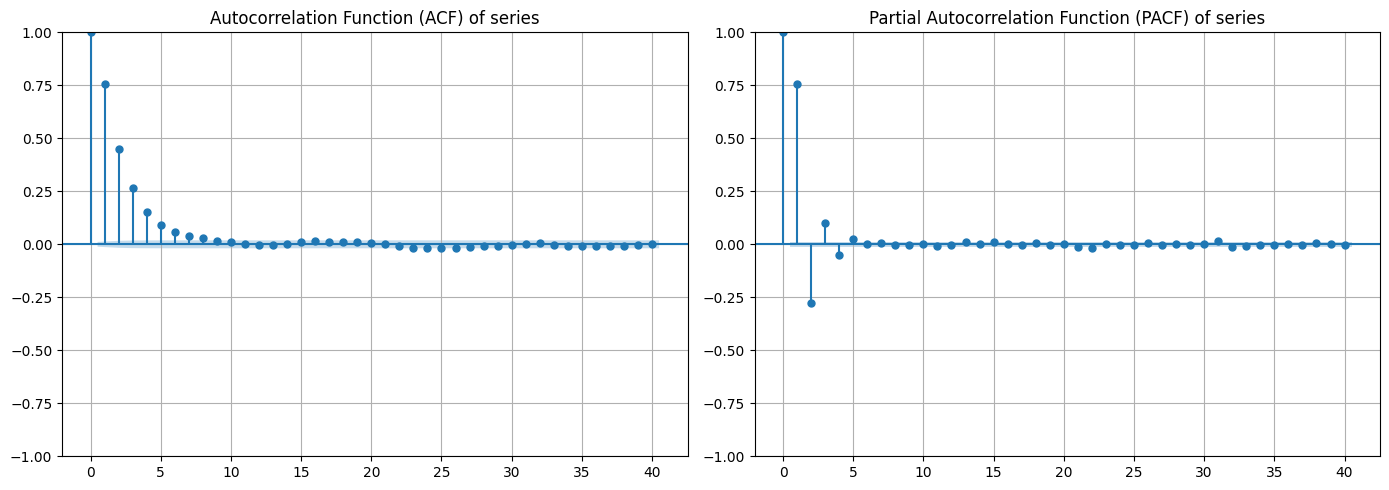

In [24]:
plot_graphs(pd.Series(X4))

In [25]:
# ------------------------
# STEP 6: Introduce ARIMA (with Integration)
# ------------------------
# 1. Create an I(1) process: X[t] = X[t-1] + eps[t]
# 2. Difference it: Y[t] = X[t] - X[t-1]
# 3. Confirm Y is stationary using ADF test
# 4. Fit ARIMA(1,1,0) and compare to AR(1) on Y

In [26]:
X, _ = lfilter([1], [1, -1], white_noise, zi = [0.0])
Y = np.diff(X, prepend=0.0)     # Y[0]=0, Y[t]=X[t]−X[t-1]=eps[t]

In [27]:
stat, p_val, _, _, cvs, _ = adfuller(Y, 5)
print(f"Y stat:{stat}, p_val:{p_val}, cvs:{cvs}")

Y stat:-173.70178478347654, p_val:0.0, cvs:{'1%': np.float64(-3.4305680025880942), '5%': np.float64(-2.8616363512511263), '10%': np.float64(-2.5668212848307097)}


In [28]:
# ------------------------
# STEP 8: Cointegration and the Error Correction Model (ECM)
# ------------------------
# 1. Simulate two price series:
#    Y[t] = 100 + 0.5 * t + e1[t]
#    X[t] = 120 + 0.5 * t + e2[t]   (both I(1), drift + noise)
# 2. Form residual: R[t] = Y[t] - beta * X[t] (choose beta = 1.0 or estimate) #Instead of subtracting ols beta to get residual...

#can we do optimization on X[t] and Y[t] s.t. R[t] is stationary?

# 3. ADF test on R[t] — if stationary, Y and X are cointegrated
# 4. Build the ECM: ΔY[t] = α * R[t-1] + γ * ΔX[t] + ε[t]
# 5. Interpret:
#    - α: error correction speed
#    - γ: short-run influence of ΔX
# 6. Plot: actual ΔY[t] vs predicted ΔY[t] from ECM


In [29]:
t = np.arange(0, n, 1)
e1 = np.random.randn(n)
e2 = np.random.randn(n)
Yt = 100 + 0.5*t + e1
Xt = 120 + 0.5*t + e2

In [30]:
Rt = Yt - Xt

In [31]:
stat, p_val, _, _, cvs, _ = adfuller(Rt, 5)
print(f"Y stat:{stat}, p_val:{p_val}, cvs:{cvs}")

Y stat:-78.98163417759682, p_val:0.0, cvs:{'1%': np.float64(-3.43056803166244), '5%': np.float64(-2.861636364100729), '10%': np.float64(-2.566821291670243)}


In [32]:
temp_df = pd.DataFrame({
    'Xt': (Xt[1:] - Xt[:-1]),
    'Rt': Rt[:-1]
})
x = sm.add_constant(temp_df)
result = sm.OLS(Yt[1:] - Yt[:-1], x).fit()

In [33]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     7564.
Date:                Wed, 21 May 2025   Prob (F-statistic):               0.00
Time:                        22:54:59   Log-Likelihood:                -47051.
No. Observations:               29999   AIC:                         9.411e+04
Df Residuals:                   29996   BIC:                         9.413e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.1744      0.111   -118.242      0.000     -13.393     -12.956
Xt             0.3379      0.006     61.312      0.000       0.327       0.349
Rt            -0.6749      0.005   -122.993      0.000      -0.686      -0.664
==============================================================================
Omnibus:                        6.528   Durbin-Watson:                   2.332
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                6.411
Skew:                           0.024   Prob(JB):                       0.0405
Kurtosis:                       2.947   Cond. No.                         334.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""